### FilterNet
A neural network for filtering out gaussian noise from an image introduced by aggressive accelerations on the vehicle carrying the camera.

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from skimage import io, transform
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from typing import List, Dict, Tuple
from tqdm import tqdm

### Dataset Class and Dataloader

In [2]:
# Set device to cuda
device = torch.device('cuda:0')

# Create dataset class
class VideoDataset(Dataset):
    def __init__(self, path_to_data, augmented=False, num_vids=7, seq_length=5, img_size=256):
        """
        Go through each video folder and build a map from
        index i in range [0, N], where N is the total number
        of frames in all the videos, to a tuple (j, k), where
        j is the video number and k the frame index in that
        video. For reference, the videos are stored in the
        dataset as:

        data:
        - test1:
          - inputs:
            - bd_poses.csv
            - bd_twists.csv
            - frame0000.png
            - frame0001.png
            - ...
          - targets:
            - frame0000.png
            - frame0001.png
            - ...
        - test2:
            - ...
        - ...
        """
        self.img_size = img_size
        self.seq_length = seq_length
        self.augmented = augmented
        self.num_vids = num_vids
        self.path_to_data = path_to_data
        self.idx_map: List[Tuple[int, int]] = []
        self.poses: Dict[int, np.ndarray] = {}
        self.twists: Dict[int, np.ndarray] = {}
        for i in tqdm(range(1, self.num_vids + 1)):
            # Define path to pose
            pose_path = os.path.join(path_to_data, f'test{i}/inputs/bd_poses.csv')
            twist_path = os.path.join(path_to_data, f'test{i}/inputs/bd_twists.csv')

            # Check that files were opened properly
            if not os.path.isfile(pose_path):
                raise FileNotFoundError(f"Missing pose file: {pose_path}")
            if not os.path.isfile(twist_path):
                raise FileNotFoundError(f"Missing twist file: {twist_path}")

            # Get poses
            self.poses[i] = pd.read_csv(pose_path).to_numpy()
            self.twists[i] = pd.read_csv(twist_path).to_numpy()

            # Get number of sequences in this video: num_frames - (seq_length - 1)
            num_sequences = (self.poses[i].shape[0] - 1) - (self.seq_length - 1)

            # Update index map
            video_num = [i] * num_sequences
            frame_idx = list(range(0, num_sequences))
            self.idx_map.extend(list(zip(video_num, frame_idx)))

        self.total_num_sequences = len(self.idx_map)

    def __len__(self):
        """
        Return length of dataset as computed in __init__() function.
        """
        return self.total_num_sequences

    def __getitem__(self, idx):
        """
        Use map built in __init__() to retrieve the image,
        pose, and twist directly from the dataset.
        This avoids loading the entire dataset which
        overwhelms RAM.
        """
        assert idx < self.total_num_sequences
        if torch.is_tensor(idx):
            idx = idx.tolist()

        seq_start = True
        for i in range(self.seq_length):
            # Define path to data
            test_idx, frame_idx = self.idx_map[idx]
            frame_idx += i
            padded_frame_idx = self.to_zero_pad_idx(frame_idx)
            input_img_path = os.path.join(self.path_to_data,
                                    f'test{test_idx}/inputs/frame{padded_frame_idx}.png')
            output_img_path = os.path.join(self.path_to_data,
                                    f'test{test_idx}/targets/frame{padded_frame_idx}.png')

            # Debug: 
            # print(f'\ntest idx, frame idx: {test_idx, frame_idx}')

            # Load and process data
            input_frame = io.imread(input_img_path)
            output_frame = io.imread(output_img_path)
            input_frame = torch.from_numpy(self.to_grayscale(input_frame)).float()
            output_frame = torch.from_numpy(self.to_grayscale(output_frame)).float()
            pose = self.poses[test_idx][frame_idx]
            pose = torch.from_numpy(self.pose_vector_from_matrix(pose).reshape(-1, 1)).float()
            twist = torch.from_numpy(self.twists[test_idx][frame_idx].reshape(-1, 1)).float()
            state = torch.cat((pose, twist), dim=0).view(-1)

            # Resize frames
            h, w = self.img_size, self.img_size
            resize_frame = transforms.Resize((h, w))
            output_frame = resize_frame(output_frame.unsqueeze(0))
            input_frame = resize_frame(input_frame.unsqueeze(0))

            if not self.augmented:
                # Initialize sequence
                if seq_start:
                    in_frame_seq = torch.zeros_like(input_frame).view(1, 1, h, w).repeat((self.seq_length, 1, 1, 1))
                    out_frame_seq = torch.zeros_like(output_frame).view(1, 1, h, w).repeat((self.seq_length, 1, 1, 1))
                    state_seq = torch.zeros_like(state).unsqueeze(0).repeat((self.seq_length, 1))
                    seq_start = False

                # Update sequence
                in_frame_seq[i] = input_frame.view(1, h, w)
                out_frame_seq[i] = output_frame.view(1, h, w)
                state_seq[i] = state

            # If we want a broadcasted frame, pose, twist tensor of shape (B, T, 1, H, W, 14)
            else:
                expanded_frame = input_frame.view(1, h, w, 1)
                expanded_state = state.view(1, 1, 1, -1).repeat(1, h, w, 1)
                augmented_frame = torch.cat((expanded_frame, expanded_state), dim=-1)

                # Initialize augmented sequence
                if seq_start:
                    aug_seq_in = torch.zeros_like(augmented_frame).unsqueeze(0).repeat((self.seq_length, 1, 1, 1, 1))
                    aug_seq_out = torch.zeros_like(output_frame).unsqueeze(0).repeat((self.seq_length, 1, 1, 1))
                    seq_start = False

                # Update augmented sequence
                aug_seq_in[i] = augmented_frame
                aug_seq_out[i] = output_frame

        return {'input': (in_frame_seq, state_seq), 'target': out_frame_seq} if not self.augmented else {'input': aug_seq_in, 'target': aug_seq_out}

    def to_zero_pad_idx(self, idx):
        """
        Convert frame index from regular index to zero-padded index.
        e.g. 1 -> 00001, 12 -> 00012
        """
        return f'{idx:05d}'

    def pose_vector_from_matrix(self, pose):
        """
        Convert 4x4 pose matrix (as a flattenned length 16 vector) into a position and quaternion length 7 vector.
        """
        pose = pose.reshape(4, 4)
        position = pose[:3, 3].reshape(3, 1)
        orientation = pose[:3, :3]

        quat = R.from_matrix(orientation).as_quat().reshape(-1, 1)
        norm_quat = quat / np.linalg.norm(quat)

        return np.vstack((position, norm_quat)).reshape(-1)

    def to_grayscale(self, image):
        """
        Convert PNG image to grayscale mask
        """
        #TODO: Try float16 type
        return (image[..., 0] > 127).astype(np.float32)


### Submodules

Here are the Encoders, Decoder, and LSTM

In [3]:
# Write classes for compression networks

#TODO: Try a conv3d encoder. conv3d layers encode temporal information. (Alternative to LSTM). An alternative to the current pipeline would
# be to use the augmented data tensor (without compressing it) and a conv3d layer to process the (T, B, 1, H, W, 14) input. Which would need to be
#reshaped to (B, 1, T, H, W, 14). I wouldn't know what to do with the state dimension. Treat them as channels (image, pose, twist)? Flatten them with the sequence dim?

class ImgEncoder(nn.Module):
    def __init__(self, in_channel=1, hidden_channel=16, out_channel=32, h_in=256, out_dim=1024):
        """
        Define convolutional neural network architecture for compressing a 256 x 256 image into a 1024 embedding vector.
        Assumes image is square.
        """
        super().__init__()

        # Compute image shape after convolution
        stride = 2
        padding_one, padding_two = 7, 1
        num_ker_one, num_ker_two = 16, 4
        h_out = (h_in + 2 * padding_one - num_ker_one) // stride + 1
        h_out = (h_out + 2 * padding_two - num_ker_two) // stride + 1

        # Define CNN
        linear_in_dim = out_channel * h_out ** 2
        linear_out_dim = out_dim
        self.conv_stack = nn.Sequential(
                            nn.Conv2d(in_channel, hidden_channel, num_ker_one, stride=stride, padding=padding_one), # h_in, w_in = (256, 256); h_out, w_out = (128, 128)
                            nn.ReLU(),
                            nn.Conv2d(hidden_channel, out_channel, num_ker_two, stride=stride, padding=padding_two), # h_in, w_in = (128, 128); h_out, w_out = (64, 64)
                            nn.ReLU(),
                            nn.Flatten(start_dim=1, end_dim=-1), # Flattens (c_out, h_out, w_out) = (32, 64, 64) into 131072
                            nn.Linear(linear_in_dim, linear_out_dim) # Encodes the 131072 length flattened convolved image into a 1024 length embedding vector
        )

    def forward(self, x):
        """
        Define neural network forward pass
        Input has shape (T, B, 1, H, W)
        """
        return self.conv_stack(x[-1])

class ImgSeqEncoder(nn.Module):
    def __init__(self, in_channel=1, hidden_channel=16, out_channel=32, h_in=256, out_dim=1024):
        """
        Define convolutional neural network architecture for compressing a SEQUENCE of 256 x 256 images into a 1024 embedding vector.
        Assumes image is square.
        """
        super().__init__()

        # Compute image shape after convolution
        stride = 2
        padding_one, padding_two = 7, 1
        num_ker_one, num_ker_two = 16, 4
        h_out = (h_in + 2 * padding_one - num_ker_one) // stride + 1
        h_out = (h_out + 2 * padding_two - num_ker_two) // stride + 1

        # Define CNN
        linear_in_dim = out_channel * h_out ** 2
        linear_out_dim = out_dim
        self.conv_stack = nn.Sequential(
                            nn.Conv2d(in_channel, hidden_channel, num_ker_one, stride=stride, padding=padding_one), # h_in, w_in = (256, 256); h_out, w_out = (128, 128)
                            nn.ReLU(),
                            nn.Conv2d(hidden_channel, out_channel, num_ker_two, stride=stride, padding=padding_two), # h_in, w_in = (128, 128); h_out, w_out = (64, 64)
                            nn.ReLU(),
                            nn.Flatten(start_dim=1, end_dim=-1), # Flattens (c_out, h_out, w_out) = (32, 64, 64) into 131072
                            nn.Linear(linear_in_dim, linear_out_dim) # Encodes the 131072 length flattened convolved image into a 1024 length embedding vector
        )

    def forward(self, x):
        """
        Define neural network forward pass
        Input has shape (T, B, 1, H, W)
        """
        seq_len, batch_size, _, h, w = x.shape
        x = x.reshape(seq_len * batch_size, 1, h, w)
        return self.conv_stack(x).reshape(seq_len, batch_size, -1)

class StateEncoder(nn.Module):
    def __init__(self, in_dim=13, out_dim=128):
        """
        Define linear layer to generate a length 128 embedding vector from length 13 pose and twist vector.
        """
        super().__init__()
        self.linear_layer = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        """
        Define nueral network forward pass
        Input has shape (T, B, D) need (B, D) 
        """
        return self.linear_layer(x[-1])
    
class StateSeqEncoder(nn.Module):
    def __init__(self, in_dim=13, out_dim=128):
        """
        Define linear layer to generate a sequence of length 128 embedding vectors from length 13 pose and twist vectors.
        """
        super().__init__()
        self.linear_layer = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        """
        Define nueral network forward pass
        """
        return self.linear_layer(x)

class ImgDecoder(nn.Module):
    def __init__(self, in_channels=5, hidden_channels=3, out_channels=1, in_dim=512, hidden_dim=4096):
        """
        Reconstructs the image from the embedding vector. (B, T, in_dim): (B, 5, 512)
        Output image size is (256, 256).
        """
        super().__init__()

        # Compute output height
        h_in = int(np.sqrt(hidden_dim))
        stride = 1
        pad_one, pad_two = 34, 71
        ker_one, ker_two = 5, 15
        self.h_out = (h_in + 2 * pad_one - ker_one) // stride + 1
        self.h_out = (self.h_out + 2 * pad_two - ker_two) // stride + 1

        # Modules
        self.decoder = nn.Sequential(
                        nn.Linear(in_dim, hidden_dim), # (B, T, hidden_dim)
                        nn.ReLU(),
                        nn.Unflatten(dim=-1, unflattened_size=(h_in, h_in)),
                        nn.Conv2d(in_channels, hidden_channels, ker_one, stride, pad_one),
                        nn.ReLU(),
                        nn.Conv2d(hidden_channels, out_channels, ker_two, stride, pad_two),
        )

    def forward(self, x):
        """
        Input has shape (T, B, D_emb) = (5, 16, 512)
        Return predicted last image in sequence (B, 1, h_out, h_out)
        It treats the input sequence dimension as an images channels dimension and it convolves
        the image back to its original dimension.

        TODO: Consider instead of passing (T, B, D_emb) as (T * B, D_emb) and reconstructing as
        (T, B, 1, h_out, h_out), pass it as (B, T * D_emb) and reconstruct as (B, 1, h_out, h_out).
        """
        return self.decoder(x.permute(1, 0, 2)) # Convnet expects (B, T, H, W)
    
class ImgDecoder2(nn.Module):
    def __init__(self, in_channels=5, hidden_channels=32, out_channels=1, in_dim=512, hidden_dim=1024, out_size=256):
        super().__init__()
        self.out_size = out_size
        h_in = int(np.sqrt(hidden_dim))

        self.decoder = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Unflatten(dim=-1, unflattened_size=(h_in, h_in)),  # (B, 5, 32, 32)
            nn.Upsample(scale_factor=2, mode='nearest'),  # (B, 5, 64, 64)
            nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # (B, 32, 128, 128)
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # (B, 16, 256, 256)
            nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return self.decoder(x.permute(1, 0, 2))
    

# Jialin Encoder
class SIRENActivation(nn.Module):
    def __init__(self, w0=30.0):
        super().__init__()
        self.w0 = w0

    def forward(self, x):
        return torch.sin(self.w0 * x)

class CNNEncoder(nn.Module):
    def __init__(self, input_channels=1, hidden_dim=1024, activation=SIRENActivation(30.0)): 
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 16, 3, padding=1),
            activation,
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            activation,
            nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.out_dim = 32 * 64 * 64  # 131072
        self.fc = nn.Linear(self.out_dim, hidden_dim)

    def forward(self, x):  # (T, B, 1, H, W)
        T, B, C, H, W = x.shape
       
        x = x.contiguous().view(T * B, C, H, W)
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = x.view(T, B, -1)

        return x  # (T, B, hidden_dim)


# Jialin State Encoder
class JStateEncoder(nn.Module):
    def __init__(self, pose_dim=13, embed_dim=128):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(pose_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, pose):  # (T, B, 13)
        return self.fc(pose)  # (T, B, embed_dim)


In [4]:
# Test conv encoder
mock_img_data = torch.zeros((5, 16, 1, 256, 256))
img_encoder = CNNEncoder()
img_embedding = img_encoder(mock_img_data)

# Test state encoder
mock_state_data = torch.zeros((5,64, 13))
state_encoder = JStateEncoder()
state_embedding = state_encoder(mock_state_data)


In [5]:
img_embedding.shape
# state_embedding.shape

torch.Size([5, 16, 1024])

In [6]:
# Vanilla LSTM
class LSTM(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_layers=1):
        super().__init__()
        self.model = nn.LSTM(in_dim, hidden_dim, num_layers=num_layers)

    def forward(self, x):
        return self.model(x)[0]

# Jialin's LSTM
class JLSTM(nn.Module):
    '''
    LSTM with the image + pose embeddings as input
    '''
    def __init__(self, input_dim, hidden_dim, n_layers=2):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=False,
            bidirectional=False
        )

    def forward(self, x):  # (T, B, input_dim)
        out, _ = self.lstm(x)
        return out  # (T, B, hidden_dim)
    

class MLP(nn.Module): 
    def __init__(self, in_dim, hidden_dim, num_layers=3):
        super().__init__()
        
        ### Create model 
        out_dim = hidden_dim 
        layers = [nn.Linear(in_dim, hidden_dim), nn.ReLU()]
        for _ in range(1, num_layers): 
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.ReLU()])
        layers.append(nn.Linear(hidden_dim, out_dim))
        self.model = nn.Sequential(*layers) 
        
    def forward(self, x):
        """
        Input has shape (B, D) and decoder Expects (1, B, D) 
        """
        x = x
        return self.model(x).unsqueeze(0)


In [7]:
# Loss functions 
class BCEDiceLoss(nn.Module):
    def __init__(self, weight_bce=0.7, weight_dice=0.3, smooth=1.0, weight=250.0):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight], device=device))
        self.weight_bce = weight_bce
        self.weight_dice = weight_dice
        self.smooth = smooth  # to avoid division by zero

    def forward(self, logits, targets):
        # BCEWithLogitsLoss expects raw logits
        bce_loss = self.bce(logits, targets)

        # Apply sigmoid to get probabilities
        probs = torch.sigmoid(logits)
        probs = probs.reshape(-1)
        targets = targets.reshape(-1)

        intersection = (probs * targets).sum()
        dice_score = (2. * intersection + self.smooth) / (
            probs.sum() + targets.sum() + self.smooth
        )
        dice_loss = 1 - dice_score

        return self.weight_bce * bce_loss + self.weight_dice * dice_loss

### FilterNet

This is the main module which contains the submodules to form a LSTM convolutional autoencoder

In [8]:
# Define LSTM class
class FilterNet(nn.Module):
    def __init__(self, in_dim=1152, hidden_dim=512, seq_length=5, augmented=False):
        """
        Define LSTM architecture with image and state encoders
        Must concatenate image and state embeddings to make a 1024 + 128 length embedding vector for lstm
        lstm input dimension is then 1024 + 128 = 1152
        """
        super().__init__()

        # Parameters
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.seq_len = seq_length
        self.augmented = augmented

        # Jialin Modules
        self.image_encoder = CNNEncoder()
        self.state_encoder = JStateEncoder()
        self.lstm = JLSTM(input_dim=in_dim, hidden_dim=hidden_dim)
        self.image_decoder = ImgDecoder(in_channels=seq_length)
        self.loss_fun = BCEDiceLoss()

        # Juan Modules 
        # self.image_encoder = ImgEncoder()
        # self.state_encoder = StateEncoder() 
        # self.lstm = MLP(in_dim, hidden_dim) 
        # self.image_decoder = ImgDecoder2(in_channels=1) # in_channels should be 5 for lstm
        # self.loss_fun = BCEDiceLoss()



    def loss(self, sequence):
        """
        Unless using the augmented (B, T, 1, H, W, 14) tensor, data will come in as a Tuple storing a sequence of {'input', 'target'}
        dictionaries. Each 'input' field contains a frame, a pose, and a twist, each as a tensor.

        Must loop through the sequence to generate embedding, but for small sequence lengths, the overhead is negligible, and actually
        preferable, than the memory overhead of the augmented tensor.
        """

        if self.augmented:
            # Retrieve data
            input, output = sequence['input'].permute(1, 0, 2, 3, 4, 5), sequence['target'].permute(1, 0, 2, 3, 4) # switch to sequence first
            frames = input[..., 0]
            state = input[:, :, :, 0, 0, 1:]
            out_frame = output[-1, ...]
        else:
            # Pass each element of the sequence through the model
            frames = sequence['input'][0].permute(1, 0, 2, 3, 4) # (B, T, 1, H, W) --> (T, B, 1, H, W)
            state = sequence['input'][1].permute(1, 0, 2) # (B, T, 13) --> (T, B, 13)
            out_frame = sequence['target'].permute(1, 0, 2, 3, 4)[-1, ...] #(T, B, 1, H, W) --> (B, 1, H, W)

        # Pass inputs through encoders
        img_embedding = self.image_encoder(frames) # out dim should be (T, B, d_img_emb)
        state_embedding = self.state_encoder(state) # out dim should be (T, B, d_state_emb)

        # Concatenate embedding vector and reconstruct sequence as a tensor
        compressed_input = torch.cat((img_embedding, state_embedding), dim=-1) # (T, B, in_dim)

        # Pass compressed sequence through LSTM
        lstm_out = self.lstm(compressed_input) # should have shape (T, B, hidden_dim) (5, 16, 512)

        # Pass through decoder to reconstruct predicted last frame in sequence
        pred_frame = self.image_decoder(lstm_out)

        # Get loss between predicted frame and last frame in target sequence
        return self.loss_fun(pred_frame, out_frame), pred_frame


In [9]:
### Test FilterNet

# Generate mock input
mock_img_npt_data = torch.zeros((16, 5, 1, 256, 256), device=device)
mock_img_trgt_data = torch.ones((16, 5, 1, 256, 256), device=device)
mock_state_data = torch.zeros((16, 5, 13), device=device)
datapoint = {'input': (mock_img_npt_data, mock_state_data), 'target': mock_img_trgt_data}

# Initialize model
filternet = FilterNet().to(device)

# Test loss function
out = filternet.loss(datapoint)
out


(tensor(120.4683, device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[[[0.0115, 0.0115, 0.0115,  ..., 0.0115, 0.0115, 0.0115],
           [0.0115, 0.0115, 0.0115,  ..., 0.0115, 0.0115, 0.0115],
           [0.0115, 0.0115, 0.0115,  ..., 0.0115, 0.0115, 0.0115],
           ...,
           [0.0115, 0.0115, 0.0115,  ..., 0.0115, 0.0115, 0.0115],
           [0.0115, 0.0115, 0.0115,  ..., 0.0115, 0.0115, 0.0115],
           [0.0115, 0.0115, 0.0115,  ..., 0.0115, 0.0115, 0.0115]]],
 
 
         [[[0.0115, 0.0115, 0.0115,  ..., 0.0115, 0.0115, 0.0115],
           [0.0115, 0.0115, 0.0115,  ..., 0.0115, 0.0115, 0.0115],
           [0.0115, 0.0115, 0.0115,  ..., 0.0115, 0.0115, 0.0115],
           ...,
           [0.0115, 0.0115, 0.0115,  ..., 0.0115, 0.0115, 0.0115],
           [0.0115, 0.0115, 0.0115,  ..., 0.0115, 0.0115, 0.0115],
           [0.0115, 0.0115, 0.0115,  ..., 0.0115, 0.0115, 0.0115]]],
 
 
         [[[0.0115, 0.0115, 0.0115,  ..., 0.0115, 0.0115, 0.0115],
           [0.0115, 0.011

### Traning Loop

In [10]:
# Define training parameters
num_epochs = 1 # originally 10
num_workers = 4
num_vids = 7 
path_to_data = 'processed_flow'
augmented = False
batch_size = 2
seq_length = 10
img_size = 256


# because mac :)
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


# TODO: Split into train and val loader
# deterministic split, same split across runs
# generator = torch.Generator().manual_seed(42)
# val_ratio = 0.2
# val_size = int(len(dataset) * val_ratio)
# train_size = len(dataset) - val_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)


dataset = VideoDataset(path_to_data, augmented=augmented, num_vids=num_vids, seq_length=seq_length, img_size=img_size)
# loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers) #NOTE: num_workers is the number of extra processes running in parallel retrieving the data


val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size

train_dataset = torch.utils.data.Subset(dataset, list(range(train_size)))
val_dataset = torch.utils.data.Subset(dataset, list(range(train_size, len(dataset))))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)

# Initialize model
model = FilterNet(seq_length=seq_length)
model = model.to(device) # added

# Initialize optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # lr = 0.001

# next(model.parameters()).device



100%|██████████| 7/7 [00:00<00:00, 58.46it/s]


In [11]:
# Training loop
import torchvision 
for epoch in range(num_epochs):
    running_loss, last_loss = 0, 0
    num_batches, epoch_loss = 0, 0
    print(f'\nEpoch {epoch + 1}/{num_epochs}:')
    for i, sequence in tqdm(enumerate(train_loader)):

        # Move data to device
        frames, state = sequence['input']
        out_frame = sequence['target']

        # NOTE: Temp: mask out the sequences with no foreground #TODO remove if no improvement
        B, T, C, H, W = frames.shape
        nonzero_mask = frames.view(B, -1).any(dim=1)
        frames = frames[nonzero_mask]
        out_frame = out_frame[nonzero_mask] 
        state = state[nonzero_mask]

        if frames.numel()==0:
            continue

        sequence['input'] = (frames.to(device), state.to(device))
        sequence['target'] = out_frame.to(device)

        # Zero gradients for every batch
        optimizer.zero_grad()

        # Compute the loss and its gradients
        loss, pred  = model.loss(sequence)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # print(pred.mean().item(), pred.std().item())
        # Gather data and report
        running_loss += loss.item()
        if i % 250 == 249: # report loss every 1000 batches
            last_loss = running_loss / 250 # loss per batch
            print(' batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0
            # with torch.no_grad():
            #     print(f'Prediction logit mean: {pred.mean().item()}, std: {pred.std().item()}, and max: {pred.max().item()} and min: {pred.min().item()}')
        

        # Update counters for average epoch loss
        epoch_loss += loss.item()
        num_batches += 1 # changed from num_epochs to num_batches

    print(f'Epoch {epoch + 1} average loss: {epoch_loss / num_batches}') # changed from num_epochs to num_batches



Epoch 1/1:


251it [00:32,  7.05it/s]

 batch 250 loss: 0.8914896967411041


502it [01:04,  9.06it/s]

 batch 500 loss: 0.9039425225257873


751it [01:36,  7.01it/s]

 batch 750 loss: 0.8367826001644134


1001it [02:06,  7.58it/s]

 batch 1000 loss: 0.8139134113788604


1252it [02:39,  9.48it/s]

 batch 1250 loss: 0.849443629026413


1501it [03:09,  7.93it/s]

 batch 1500 loss: 0.7611597282886505


1751it [03:41,  7.15it/s]

 batch 1750 loss: 0.8010589034557343


2001it [04:12,  8.22it/s]

 batch 2000 loss: 0.8029398746490478


2251it [04:44,  7.55it/s]

 batch 2250 loss: 0.7953892464637756


2501it [05:15,  8.39it/s]

 batch 2500 loss: 0.7999122714996338


2750it [05:47,  9.71it/s]

 batch 2750 loss: 0.7808663251399994


3001it [06:19,  7.95it/s]

 batch 3000 loss: 0.7976533007621766


3252it [06:50,  9.16it/s]

 batch 3250 loss: 0.8080524234771729


3501it [07:22,  8.14it/s]

 batch 3500 loss: 0.7962880284786225


3751it [07:54,  7.06it/s]

 batch 3750 loss: 0.7935511705875397


4001it [08:26,  7.76it/s]

 batch 4000 loss: 0.8092496230602264


4251it [08:57,  7.96it/s]

 batch 4250 loss: 0.7946123251914978


4501it [09:29,  7.76it/s]

 batch 4500 loss: 0.8206533982753753


4751it [10:01,  7.49it/s]

 batch 4750 loss: 0.799527526140213


5002it [10:33, 10.01it/s]

 batch 5000 loss: 0.7691213488578796


5501it [11:34,  7.58it/s]

 batch 5500 loss: 1.4886365203857421


5752it [12:06,  9.07it/s]

 batch 5750 loss: 0.8116776077747345


6001it [12:37,  6.77it/s]

 batch 6000 loss: 0.7798666143417359


6251it [13:08,  6.90it/s]

 batch 6250 loss: 0.758968653678894


6501it [13:40,  7.63it/s]

 batch 6500 loss: 0.7429077937602997


6751it [14:12,  7.13it/s]

 batch 6750 loss: 0.7886295380592346


7001it [14:44,  7.54it/s]

 batch 7000 loss: 0.7572332458496094


7251it [15:15,  8.41it/s]

 batch 7250 loss: 0.6753414828777313


7501it [15:47,  7.24it/s]

 batch 7500 loss: 0.8711977210044861


7751it [16:18,  7.16it/s]

 batch 7750 loss: 0.7273710174560547


8000it [16:50,  8.95it/s]

 batch 8000 loss: 0.7618447117805481


8250it [17:20, 10.35it/s]

 batch 8250 loss: 0.7020795512199401


8501it [17:52,  6.99it/s]

 batch 8500 loss: 0.713127231836319


8528it [17:55,  7.93it/s]

Epoch 1 average loss: 0.8667849583091201


### Testing:


#### Testing model 

In [12]:
# Reimplemnt pose matrix to vector >:(

def pose_vector_from_matrix(pose, seq_length):
    """
    Convert 4x4 pose matrix (as a flattenned length 16 vector) into a position and quaternion length 7 vector.
    """
    pose = pose.reshape(seq_length, 4, 4)
    position = pose[:, :3, 3].reshape(seq_length, 3)
    orientation = pose[:, :3, :3]

    quat = R.from_matrix(orientation).as_quat().reshape(seq_length, 4)
    norm_quat = quat / np.linalg.norm(quat)

    return np.hstack((position, norm_quat))

In [26]:
# Load noisy sequence 
path_to_sequence = 'processed_flow/test3/inputs'
sequence_start = 2559 #2559
sequence = torch.zeros((seq_length, 1, 480, 848))

for i in range(seq_length): 
    idx = sequence_start + i 
    img = io.imread(os.path.join(path_to_sequence, f'frame{idx:05d}.png'))
    img = torch.from_numpy((img[..., 0] > 127).astype(np.float32))
    sequence[i] = img 

transform = transforms.Resize((256, 256)) 
sequence = transform(sequence) 
sequence = sequence.unsqueeze(0).float() # Add batch dimension 


# Load pose and twist 
pose = pd.read_csv(os.path.join(path_to_sequence, 'bd_poses.csv')).to_numpy()[sequence_start:sequence_start + seq_length, :]
pose = pose_vector_from_matrix(pose, seq_length)
twist = pd.read_csv(os.path.join(path_to_sequence, 'bd_twists.csv')).to_numpy()[sequence_start:sequence_start + seq_length, :]
state = torch.from_numpy(np.hstack((pose, twist)))
state = state.unsqueeze(0).float() # Add batch dimension 

# Make dummy output 
out_seq = torch.zeros_like(sequence) 

# Build input dict 
datapoint = {'input': (sequence.to(device), state.to(device)), 'target': out_seq.to(device)} 

# Save og image for plotting 
og_image = sequence[0, -1, 0, :, :].detach().numpy().copy()
target = out_seq[0, -1, 0, :, :].detach().numpy().copy()


In [14]:
# Test model 
model.eval() 
_, pred_frame = model.loss(datapoint)



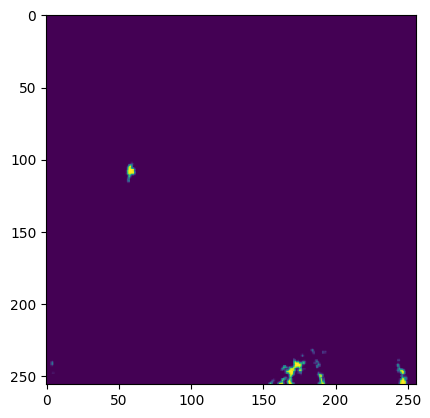

In [27]:
# Plot output frame 
plt.imshow(og_image)

tensor(0.8087, device='cuda:0', grad_fn=<MaxBackward1>)

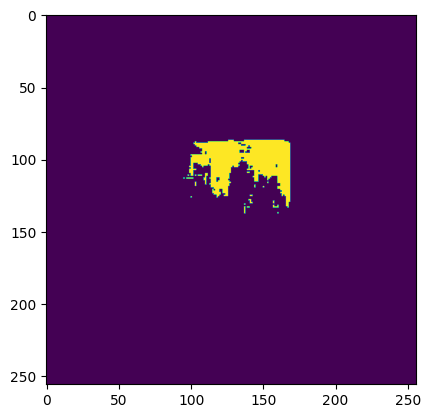

In [16]:
prob_pred_frame = torch.sigmoid(pred_frame)
out = (prob_pred_frame > 0.5).to(torch.float32) 
plt.imshow(out[0, 0, :, :].cpu().detach().numpy())
out.max()
prob_pred_frame.max()

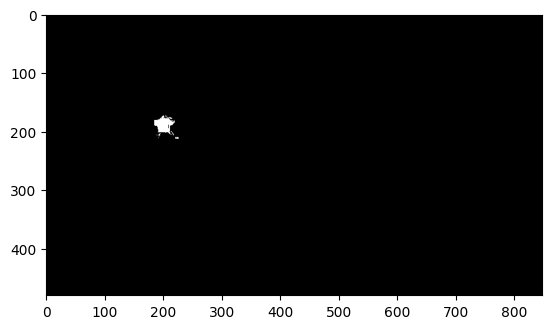

In [17]:
# Actual gt 
path_to_sequence = 'processed_flow/test3/targets'
idx = sequence_start + 4
img = io.imread(os.path.join(path_to_sequence, f'frame{idx:05d}.png'))
plt.imshow(img)

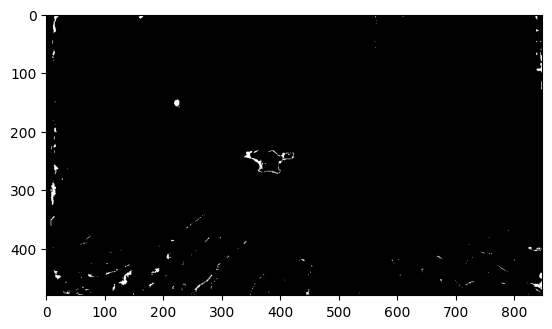

In [18]:
# Actual gt 
path_to_sequence = 'processed_flow/test1/inputs'
sequence_start = 1500
idx = sequence_start + 4
img = io.imread(os.path.join(path_to_sequence, f'frame{idx:05d}.png'))
plt.imshow(img)

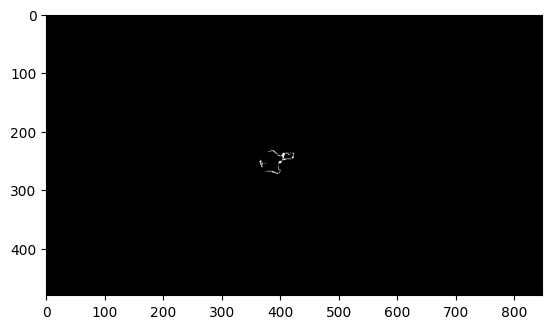

In [19]:
# Actual gt 
path_to_sequence = 'processed_flow/test1/targets'
idx = sequence_start + 4
img = io.imread(os.path.join(path_to_sequence, f'frame{idx:05d}.png'))
plt.imshow(img)

#### Testing dataloader

In [20]:
batch_size = 1
dataset = VideoDataset(path_to_data, augmented=augmented, num_vids=7, seq_length=seq_length, img_size=img_size)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0) #NOTE: num_workers is the number of extra processes running in parallel retrieving the data
counter = 0
for datapoint in loader:
    # found_one = False
    # features = datapoint['input']
    # labels = datapoint['target']
    if counter > 1:
        break
    counter += 1
    # for i in range(batch_size):
    #     image = features[0][i]
    #     if counter > 1502:
    #         found_one = True
    #         break
    #     counter += 1

    # if found_one:
    #     break

# counter
# len(datapoint)
in_frame = datapoint['input'][0][0, -1, 0, :, :]
out_frame = datapoint['target'][0, -1, 0, :, :]
# datapoint['input'][:, 0, :, :, :, 1]
# counter

100%|██████████| 7/7 [00:00<00:00, 68.53it/s]


In [21]:
# Use transforms to resize images
# This is an example, but it must actually be performed before feeding image data to encoder
# For the augmented tensor the image is already resized inside the dataloader

sequence = next(iter(loader))
if augmented:
    input, target = sequence['input'], sequence['target']
    print(f'Tensor shape should be: [{batch_size, seq_length, 1, img_size, img_size, 14}] and is: {input.shape}')
else:

    features = sequence
    image = features['input'][0]
    input, target = features['input'], features['target']
    print(f'\nBatched image shape should be: [{batch_size, seq_length, 1, img_size, img_size}] and is: {image.shape}')



Batched image shape should be: [(1, 10, 1, 256, 256)] and is: torch.Size([1, 10, 1, 256, 256])


tensor(0.)


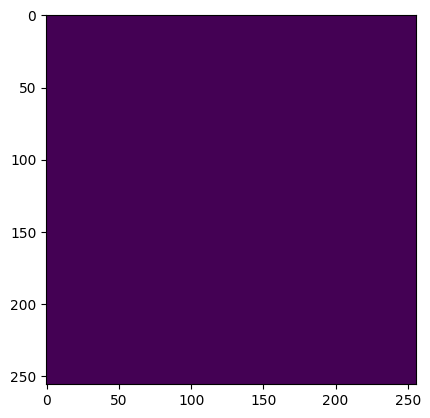

In [22]:
print(in_frame.max())
plt.imshow(in_frame)

tensor(0.)


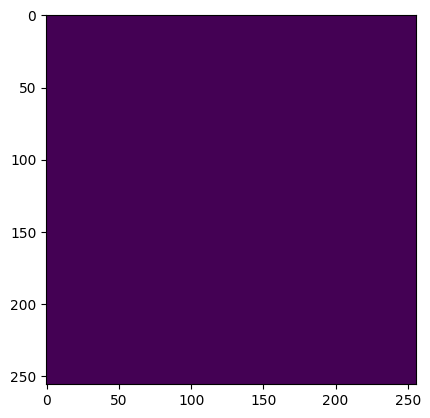

In [23]:
print(out_frame.max())
plt.imshow(out_frame)

In [24]:
features[0].shape
counter

KeyError: 0

In [ ]:
pose = features[1]
pose[28]

#### Testing interpolated twist

In [ ]:
features[1]
twist = features[2]

plt.plot(pose[:, 0])
plt.plot(twist[:, 0])
plt.legend(["pos_x", "vel_x"])
plt.show()

In [ ]:
image = features[0][28]
image.max()
plt.imshow(image)